This notebook is meant to be run in the [data-science jupyter notebook stack](https://github.com/jupyter/docker-stacks/tree/master/datascience-notebook). The main dependencies are scikit-learn, numpy and matplotlib, as well as `time` to benchmark different algorithms.

In [1]:
%matplotlib inline
import time
import sklearn.cluster as cl
import sklearn.metrics as mt
import sklearn.utils as ut
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Simple simulations: mixture of Gaussians
## Simulate time series
Let's start with a function which simulates time series. The simulation uses the following parameters:

In [268]:
n_time = 100     # number of time samples
n_roi = 150      # number of regions
n_clusters = np.array([5])   # number  of clusters 
alpha = 0.3     # this parameter controls the "strength" of the clustering.

The following function deals with the simulation of the time series, and uses a mixture model of Gaussians. The function also supports multiresolution clusters, but we will get at that latter. For now we start with a small number of regions (300), a small number of regions (300) and 5 clusters of equal size. The `alpha` parameter is set quite low (SNR of about 0.1), so that there is a challenge.

In [269]:
def simu_tseries(n_time,n_roi,n_clusters,alpha) :
    y = np.random.normal(size=[n_roi , n_time])
    gt = np.zeros(shape=[n_roi,n_clusters.size])
    
    for ss in range(0,n_clusters.size) :
        ind = np.linspace(0,n_roi,n_clusters[ss]+1,dtype="int")
        for cc in range(0, n_clusters[ss]) :
            cluster = range(ind[cc],ind[cc+1])
            sig = np.random.normal(size=[1,n_time])
            y[cluster,:] = y[cluster,:] + alpha * np.repeat(sig,ind[cc+1]-ind[cc],0)
            gt[cluster,ss] = cc
    return y , gt

Let's simulate the time series, and visualize the correspoding matrix of time correlation coefficients across regions.

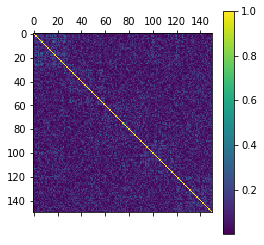

In [270]:
y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )
R = sp.corrcoef(y)
plt.matshow(np.abs(R))
plt.colorbar()

The `simu_tseries` function also create a vector of integer labels, which defines the true cluster structure.

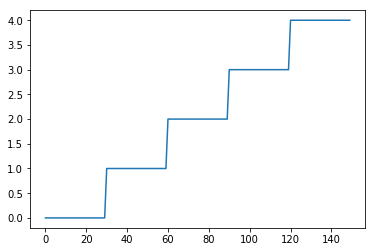

In [271]:
plt.plot(gt)

## k-means clustering
Let's try to recover the clusters with k-means clustering.

0.03545099999996637 seconds process time
Model performance (adjusted rand):  0.56192235664


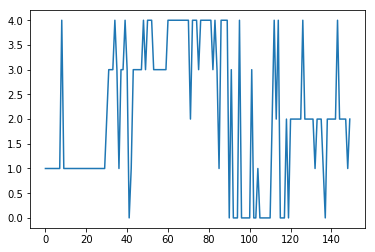

In [275]:
t0 = time.clock()
cent , part , inert  = cl.k_means(y,n_clusters=5,init="random",max_iter=30)
print(time.clock()-t0, "seconds process time")
plt.plot(part)
perf = mt.normalized_mutual_info_score(part,gt[:,0])
print("Model performance (adjusted rand): " , perf)

Let's compute the similarity between the estimated cluster structure and the real (ground truth) structure.

Not bad! Let's check how consistent this performance is with a batch of 1000 simulations:

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


0.37339499067211696

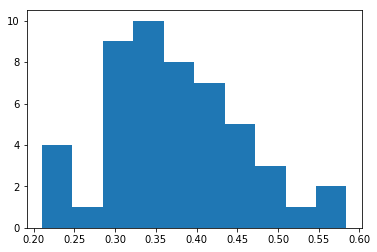

In [278]:
n_simu = 50
perf = np.zeros(n_simu)
for ss in range(0,n_simu) :
    y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )
    cent , part , inert  = cl.k_means(y,n_clusters=5,init="random",max_iter=30)
    perf[ss] = mt.normalized_mutual_info_score(part,gt[:,0])
    print("%i" % ss)
plt.hist(perf)
perf.mean()

## Evidence accumulation
Now let's try out the evidence accumulation algorithm from Fred and Jain. The idea is simply to replicate the k-means solution multiple times (with random seeds), represent each cluster solution as an adjacency matrix, and average them. This average "stability" or "co-occurence" matrix is fed into a clustering procedure as a feature matrix.

In [279]:
def eac( y , n_clusters , n_samp = 30  ) :
    for ss in range(0,n_samp) :
        cent , part , inert  = cl.k_means(y,n_clusters=n_clusters,init="random",max_iter=30)
        part = np.reshape(part,[part.shape[0],1])
        adj = np.repeat(part,part.shape[0],1) == np.repeat(part.transpose(),part.shape[0],0)
        if ss == 0 :
            stab = adj.astype(int)
        else :
            stab = adj + stab
    cent, cons , inert = cl.k_means(stab,n_clusters=n_clusters,init="random",max_iter=30)
    return cons, stab

Model performance (adjusted rand):  0.585236462876


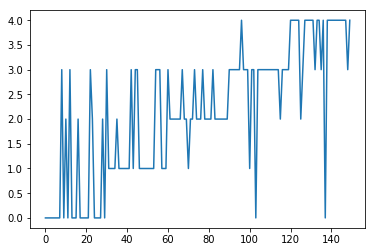

In [291]:
cons , stab = eac(y,n_clusters=5)
plt.plot(cons)
perf = mt.normalized_mutual_info_score(cons,gt[:,0])
print("Model performance (adjusted rand): " , perf)

0.5182459999998628 seconds process time


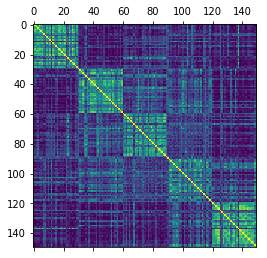

In [286]:
t0 = time.clock()
cons , stab = eac(y,n_clusters=5)
print(time.clock()-t0, "seconds process time")
plt.matshow(stab)

Let's evaluate the performance of our accumulation algorithm:

In [282]:
n_simu = 50
perf = np.zeros(n_simu)
for ss in range(0,n_simu) :
    y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )
    cons , stab = eac(y,n_clusters=5)
    perf[ss] = mt.normalized_mutual_info_score(cons,gt[:,0])
    print("%i" % ss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


0.63174561292024833

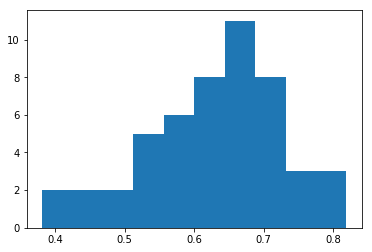

In [283]:
plt.hist(perf)
perf.mean()

## Spectral cluster bagging
EAC is much slower than k-means, but it also uses much more memory. That's because it builds a p x p matrices, where p is the number of points to classify, while k-means uses a p x k array, where k is the desired number of clusters. The idea of the spectral cluster bagging is to represent partitions using indicator vectors, and replace the averaging by a special value decomposition.

In [284]:
def scb(y , n_clusters , n_batch = 3 , n_samp = 10 ) :
    dimv = n_clusters
    vecb = np.zeros([y.shape[0],dimv,n_batch])
    for bb in range(0,n_batch) :
        vec = np.zeros([y.shape[0],dimv,n_samp])
        for ss in range(0,n_samp) :
            cent , part , inert  = cl.k_means(y,n_clusters=n_clusters,init="random",max_iter=30)
            for cc in range(0,n_clusters) :
                vec[:,cc,ss] = part == cc
        vec = vec.astype(int)
        vec = vec.reshape([y.shape[0],dimv*n_samp])
        u, s, vh = np.linalg.svd(vec, full_matrices=False)
        vecb[:,:,bb] = u[:,0:dimv]
    vecb = vecb.reshape([y.shape[0],dimv*n_batch])
    u, s, vh = np.linalg.svd(vecb, full_matrices=False)
    u = u[:,0:dimv]
    beta = np.matmul(u.transpose(),y)
    yh = np.matmul(u,beta)
    cent , cons , inert  = cl.k_means(yh,n_clusters=n_clusters,init="random",max_iter=30)
    return cons, yh
                

2.626642999999831 seconds process time


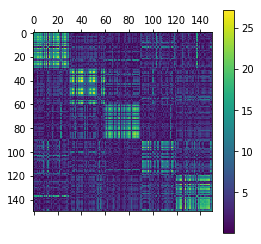

In [288]:
t0 = time.clock()
cons, yh = scb(y , n_clusters=5 , n_batch=3 , n_samp=10)
print(time.clock()-t0, "seconds process time")
R = np.matmul(yh,yh.transpose())
plt.matshow(np.abs(R))
plt.colorbar()

Model performance (adjusted rand):  0.570718972087


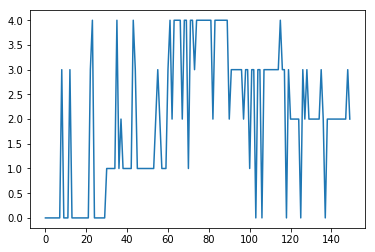

In [290]:
plt.plot(cons)
perf = mt.normalized_mutual_info_score(cons,gt[:,0])
print("Model performance (adjusted rand): " , perf)

Let's evaluate the performance of the spectral cluster aggregation

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


0.62807950131937451

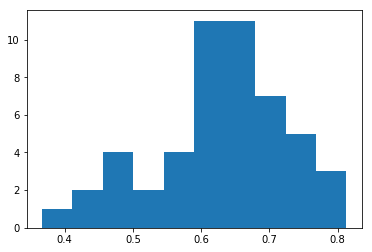

In [292]:
n_simu = 50
perf = np.zeros(n_simu)
for ss in range(0,n_simu) :
    y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )
    cons, yh = scb(y,n_clusters=5)
    perf[ss] = mt.normalized_mutual_info_score(cons,gt[:,0])
    print("%i" % ss)
plt.hist(perf)
perf.mean()

## K-means ++
Let's compare with a slightly better technique, which has good initialization for k-means.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


0.6769401690636464

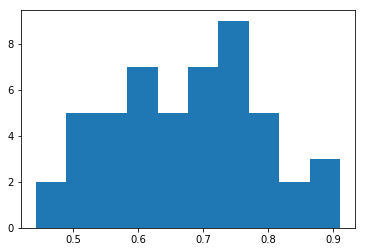

In [304]:
n_simu = 50
perf = np.zeros(n_simu)
for ss in range(0,n_simu) :
    y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )
    cent , part , inert  = cl.k_means(y,n_clusters=5,init="k-means++",max_iter=100)
    perf[ss] = mt.normalized_mutual_info_score(part,gt[:,0])
    print("%i" % ss)
plt.hist(perf)
perf.mean()

So k-means++ is faster, and gets even more accurate than SCA. But we can SCA based on k-means++ ...

In [305]:
def scapp(y , n_clusters , n_batch = 3 , n_samp = 10 ) :
    dimv = n_clusters
    vecb = np.zeros([y.shape[0],dimv,n_batch])
    for bb in range(0,n_batch) :
        vec = np.zeros([y.shape[0],dimv,n_samp])
        for ss in range(0,n_samp) :
            cent , part , inert  = cl.k_means(y,n_clusters=n_clusters,init="k-means++",max_iter=30)
            for cc in range(0,n_clusters) :
                vec[:,cc,ss] = part == cc
        vec = vec.astype(int)
        vec = vec.reshape([y.shape[0],dimv*n_samp])
        u, s, vh = np.linalg.svd(vec, full_matrices=False)
        vecb[:,:,bb] = u[:,0:dimv]
    vecb = vecb.reshape([y.shape[0],dimv*n_batch])
    u, s, vh = np.linalg.svd(vecb, full_matrices=False)
    u = u[:,0:dimv]
    beta = np.matmul(u.transpose(),y)
    yh = np.matmul(u,beta)
    cent , cons , inert  = cl.k_means(yh,n_clusters=n_clusters,init="k-means++",max_iter=30)
    return cons, yh
                

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


0.84150698027377957

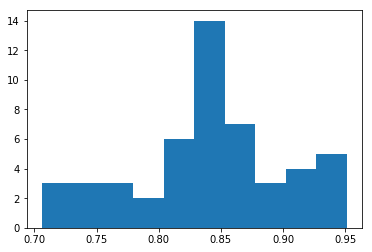

In [306]:
n_simu = 50
perf = np.zeros(n_simu)
for ss in range(0,n_simu) :
    y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )
    cons, yh = scapp(y,n_clusters=5)
    perf[ss] = mt.normalized_mutual_info_score(cons,gt[:,0])
    print("%i" % ss)
plt.hist(perf)
perf.mean()

Yeah! So SCA++ improves substantially over k-means++, just like SCA improved over regular k-means. Here the jump in performance is 20% in average normalized rand.

# Multiresolution clusters
Let's spice it up by adding a multiresolution clustering structure, which is strongly present in brain networks (and many other networks). 

In [293]:
n_clusters = np.array([5 , 10])  # # of clusters 
alpha = 0.3

The multiresolution structure is apparent as a checkerboard effect along the diagonal of the correlation matrix.

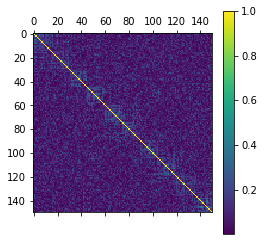

In [294]:
y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )
R = sp.corrcoef(y)
plt.matshow(np.abs(R))
plt.colorbar()

The multiresolution structure is now encoded in two separate "ground truth" columns inside `gt`.

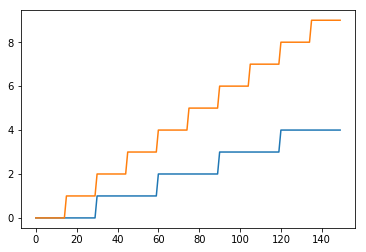

In [295]:
plt.plot(gt)

## k-means clustering

0.02882099999987986 seconds process time


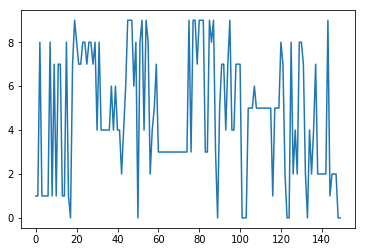

In [296]:
t0 = time.clock()
cent , part , inert  = cl.k_means(y,n_clusters=10,init="random",max_iter=30)
print(time.clock()-t0, "seconds process time")
plt.plot(part)

In [297]:
perf = mt.normalized_mutual_info_score(part,gt[:,1])
perf

0.50872068883686317

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


0.5676698391614371

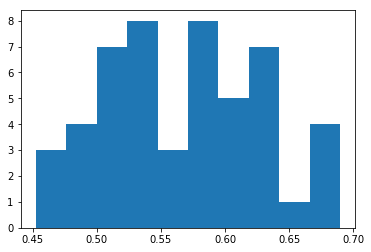

In [299]:
nb_simu = 50
perf = np.zeros(n_simu)
for ss in range(0,n_simu) :
    y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )
    cent , part , inert  = cl.k_means(y,n_clusters=10,init="random",max_iter=30)
    perf[ss] = mt.normalized_mutual_info_score(part,gt[:,1])
    print("%i" % ss)
plt.hist(perf)
perf.mean()

## Spectral cluster bagging

2.596512999999959 seconds process time


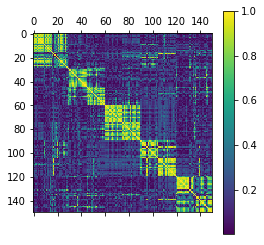

In [300]:
t0 = time.clock()
cons, yh = scb(y , n_clusters=10 , n_batch=3 , n_samp=10)
print(time.clock()-t0, "seconds process time")
R = sp.corrcoef(yh)
plt.matshow(np.abs(R))
plt.colorbar()

Model performance (adjusted rand):  0.731872282643


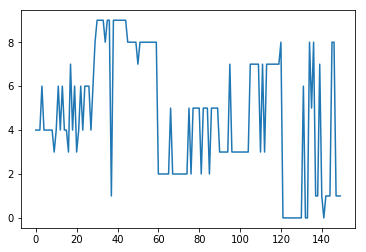

In [301]:
plt.plot(cons)
perf = mt.normalized_mutual_info_score(cons,gt[:,1])
print("Model performance (adjusted rand): " , perf)

In [302]:
nb_simu = 50
perf = np.zeros(nb_simu)
for ss in range(0,nb_simu) :
    y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )
    cons, yh = scb(y,n_clusters=10)
    perf[ss] = mt.normalized_mutual_info_score(cons,gt[:,0])
    print("%i" % ss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


0.72877094726144842

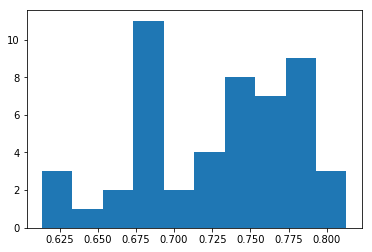

In [303]:
plt.hist(perf)
perf.mean()

# Scaling up the data
So now comes the big question: does SCA scale in memory requirements? I may have missed something important in the implementation, but in principle yes. We also need to check that execution time does not explode with spatial resolution. So let's go.

In [310]:
n_time = 300     # number of time samples
n_roi = 10000      # number of regions
n_clusters = np.array([5 , 10 , 100])   # number  of clusters 
alpha = 0.3     # this parameter controls the "strength" of the clustering.
y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )

Moment of truth... monitoring the RAM on my system. 5.2 GB used / 7.5 GB before starting the experiment.

In [312]:
t0 = time.clock()
cons, yh = scb(y , n_clusters=10 , n_batch=3 , n_samp=10)
print(time.clock()-t0, "seconds process time")

62.88573300000007 seconds process time


Whoa!! RAM stayed at exactly 5.2 GB. And the whole run completed in just over a minute. Which means that on a supercomputer we can run large scale validations, probably using the full fMRI resolution.

Model performance (adjusted rand):  0.955425304399


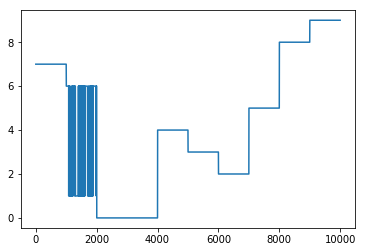

In [313]:
plt.plot(cons)
perf = mt.normalized_mutual_info_score(cons,gt[:,1])
print("Model performance (adjusted rand): " , perf)

Performance is also excellent, and I have not even used SCA++.